##### library

In [117]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import add_dummy_feature

from scipy import stats
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

warnings.filterwarnings('ignore')

##### data load

In [144]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [145]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 37.83it/s]


##### data EDA

In [146]:
# eda를 위한 data 추출
eda_df = df.loc[df["_type"] == "train"]

In [147]:
# data의 간단한 information 확인
eda_df.describe()

,target,hourly_market-data_open-interest_deribit_open_interest,hourly_market-data_liquidations_deribit_all_symbol_long_liquidations,hourly_market-data_liquidations_deribit_all_symbol_short_liquidations,hourly_market-data_liquidations_deribit_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_deribit_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_bitmex_btc_usd_open_interest,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,...,hourly_market-data_open-interest_gate_io_btc_usdt_open_interest,hourly_market-data_liquidations_gate_io_btc_usd_long_liquidations,hourly_market-data_liquidations_gate_io_btc_usd_short_liquidations,hourly_market-data_liquidations_gate_io_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_gate_io_btc_usd_short_liquidations_usd,hourly_market-data_liquidations_bybit_btc_usd_long_liquidations,hourly_market-data_liquidations_bybit_btc_usd_short_liquidations,hourly_market-data_liquidations_bybit_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_bybit_btc_usd_short_liquidations_usd,hourly_market-data_open-interest_huobi_global_all_symbol_open_interest
count,8760.000000,0.0,8752.000000,8752.000000,8.752000e+03,8.752000e+03,8.759000e+03,8760.000000,8760.000000,8.760000e+03,...,8.753000e+03,8753.000000,8753.000000,8.753000e+03,8.753000e+03,8759.000000,8759.000000,8.759000e+03,8.759000e+03,8.759000e+03
mean,1.518379,NaN,0.413765,0.424607,1.050131e+04,1.125537e+04,2.045803e+08,2.421750,2.237685,6.863825e+04,...,4.745377e+08,0.084573,0.045821,2.363938e+03,1.256123e+03,1.500767,0.976486,4.145305e+04,2.683626e+04,1.128490e+08
std,0.776190,NaN,13.529239,10.400298,3.484047e+05,2.761324e+05,3.926475e+07,8.376351,9.508053,2.337151e+05,...,1.432982e+08,1.179888,0.920113,3.356867e+04,2.519174e+04,9.050055,6.931851,2.479830e+05,1.869249e+05,1.599439e+07
min,0.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00,1.506339e+08,0.000000,0.000000,0.000000e+00,...,6.343882e+07,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,7.142407e+07
25%,1.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00,1.825740e+08,0.000000,0.000000,0.000000e+00,...,3.706644e+08,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.017707e+08
50%,2.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00,1.954768e+08,0.105000,0.051000,2.915400e+03,...,4.380881e+08,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.150261e+08
75%,2.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00,2.085644e+08,1.254250,0.956250,3.582330e+04,...,6.150821e+08,0.000000,0.000000,0.000000e+00,0.000000e+00,0.133705,0.032080,3.851500e+03,9.100000e+02,1.240815e+08
max,3.000000,NaN,997.262860,540.727466,2.659972e+07,1.372551e+07,4.414455e+08,169.736287,271.813104,4.186308e+06,...,8.420345e+08,48.672560,56.032908,1.323177e+06,1.516581e+06,245.368501,269.803680,5.643530e+06,6.934348e+06,1.554830e+08


In [148]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Columns: 255 entries, ID to hourly_market-data_open-interest_huobi_global_all_symbol_open_interest
dtypes: float64(250), int64(3), object(2)
memory usage: 17.1+ MB


In [149]:
# data type 확인
print(eda_df.dtypes)
# data type의 unique 수(catogrical, continuous 등 확인)
print(set(list(eda_df.dtypes)))

fl_num = 0
ob_num = 0
for df_type in eda_df.dtypes:
    if (df_type == 'float64') | (df_type == 'int64'):
        fl_num += 1
    elif df_type == 'object':
        ob_num += 1
# categorical과 numeric 확인
print('numeric_num :', fl_num, 'and categorical_num : ', ob_num)

ID                                                                         object
target                                                                    float64
_type                                                                      object
hourly_market-data_open-interest_deribit_open_interest                    float64
hourly_market-data_liquidations_deribit_all_symbol_long_liquidations      float64
                                                                           ...   
hourly_market-data_liquidations_bybit_btc_usd_long_liquidations           float64
hourly_market-data_liquidations_bybit_btc_usd_short_liquidations          float64
hourly_market-data_liquidations_bybit_btc_usd_long_liquidations_usd       float64
hourly_market-data_liquidations_bybit_btc_usd_short_liquidations_usd      float64
hourly_market-data_open-interest_huobi_global_all_symbol_open_interest    float64
Length: 255, dtype: object
{dtype('int64'), dtype('O'), dtype('float64')}
numeric_num : 253 and ca

1. 총 252개(target 제외) 변수 확인
3. 모든 변수들이 numeric(float or int 값)
2. NaN 값들로만 채워진 데이터들 존재 -> 결측치 처리방법 생각해야함

##### data proprocessing

In [150]:
# missing value check

# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = eda_df.isnull().sum()
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

In [151]:
new_data = eda_df[['ID','target','_type'] + non_missing_columns]
new_data.head(3)

,ID,target,_type,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,...,197.5161,0.00000,3.412540e+07,37752,0.561037,9271.503609,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,1.0,train,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,...,0.0000,11833.56104,3.456750e+07,20534,0.256248,4237.095391,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,1.0,train,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,...,0.0000,0.00000,3.452090e+07,19369,0.312978,5176.614029,0.0,0.0,0.0,0.0


In [152]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

In [153]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_df[col]).any()) | (np.isinf(new_df[col]).any()):
        print(col)
        break


In [154]:
# 각 데이터에 대한 정상성 확인
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return kpss_output['p-value']

In [155]:
non_stationality_column = []
stationality_column = []
for col in non_missing_columns:
    if kpss_test(new_df_stab[col]) < 0.05:
        non_stationality_column.append(col)
    else:
        stationality_column.append(col)

# 정상성을 만족하지 않는 데이터 개수 확인
print("정상성을 만족하는 데이터 수 : ", len(stationality_column))
print("정상성을 만족하지 않는 데이터 수 : ", len(non_stationality_column))

정상성을 만족하는 데이터 수 :  46
정상성을 만족하지 않는 데이터 수 :  166


In [156]:
# 정상성을 만족하도록 변형(차분 or 변환)
non_station_df = new_df[['ID'] + non_stationality_column]

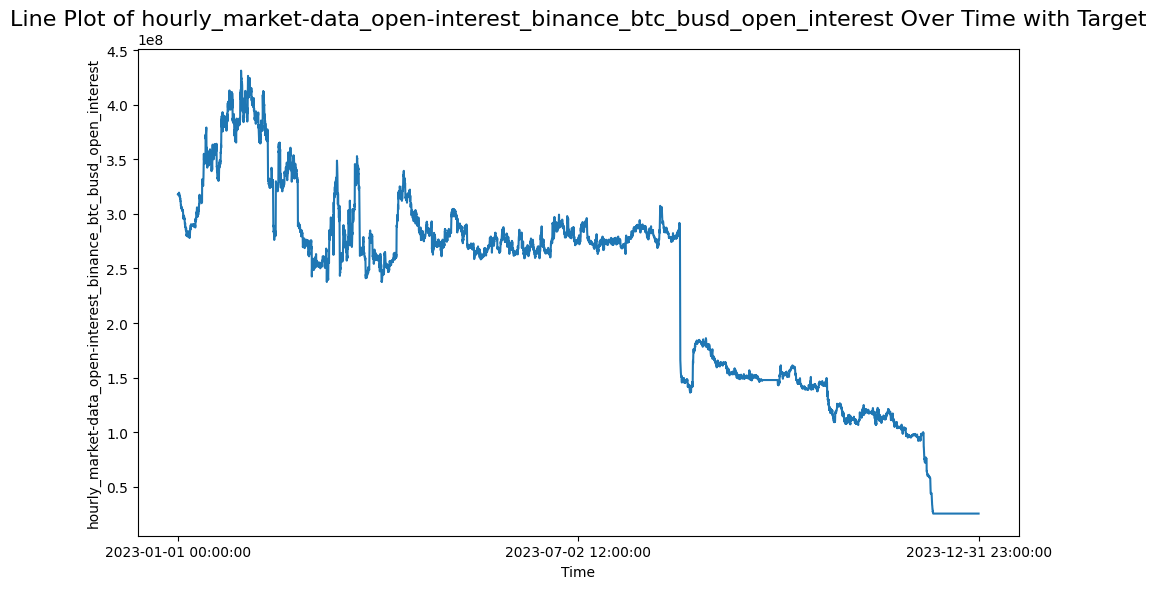

In [157]:
# 정상성이 아닌 데이터 그래프 확인
non_stationality_column_df = non_station_df[['ID', non_stationality_column[0]]]

plt.figure(figsize=(10, 6))
sns.lineplot(data=non_stationality_column_df, x='ID', y=non_stationality_column[0])
plt.xlabel('Time')
plt.title(f'Line Plot of '+ non_stationality_column[0] + ' Over Time with Target', fontsize=16)

# x축에 첨과 끝, 중간 레이블만 표시

first = non_stationality_column_df['ID'][0]
middle = non_stationality_column_df['ID'][len(non_stationality_column_df) // 2]
last = non_stationality_column_df['ID'][len(non_stationality_column_df)-1]

xticks = [first, middle, last]
plt.xticks(xticks)
plt.tight_layout()
plt.show()

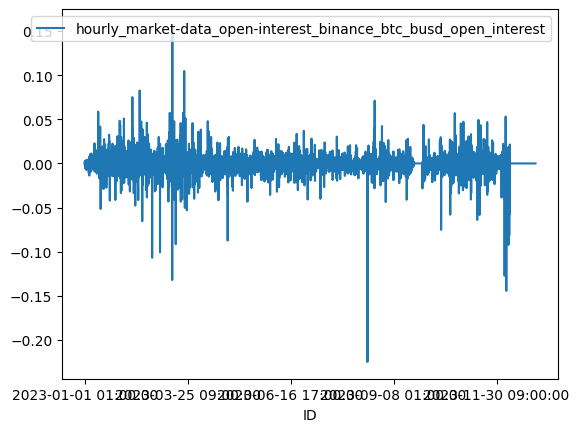

In [158]:
df_non = non_stationality_column_df.set_index('ID')
# 해당 변수 log 변환 후 그래프 확인
diff_data = np.log(df_non).diff(1).dropna()
diff_data.plot()
plt.show()

In [159]:
# 모든 non-stationality column에 대해 변환 + 차분을 실행하여 정상성으로 변환
# 변환 -> yeo-johnson로 최적의 lambda를 찾은 뒤 실행
# 차분은 1~3차 차분을 실행한 뒤 가장 kpss 검정을 통한 p-value가 가장 낮은 차분으로 값 대체

def stationality_changing_funtion(df, col, time = 'ID'):
    # data 정의
    data = df[[time, col]]
    data = data.set_index(time)

    # box-cox 변환의 일반화인 yeo-johnson 변환 실시
    transformed_data, lambda_opt = stats.yeojohnson(data[col])
    data_boxcox = data.copy()
    data_boxcox[col]= transformed_data

    p_value_list = []

    # 3차 차분의 결과를 kpss 검정을 돌려 각 p-value 값 확인
    for i in range(1,4):
        diff_data = data_boxcox.diff(i).dropna()
        p_value = kpss_test(diff_data[col])       
        p_value_list.append((i, p_value))

    
    # 두 번째 값 중 가장 큰 값을 찾기
    max_value = max(item[1] for item in p_value_list)

    num = 0

    if max_value >= 0.05:
        num += 1

    # 두 번째 값이 max_value인 원소들 필터링
    result = [item for item in p_value_list if item[1] == max_value]

    p_value_list_sorted = sorted(result, key=lambda x: x[0])


    # 가장 p-value가 큰 차분을 선택(kpss의 귀무가설을 채택하여 정상성이 나타남)
    diff_opt = p_value_list_sorted[0][0]

    diff_data_opt = data_boxcox.diff(diff_opt)
    diff_data_opt.iloc[0] = data_boxcox.iloc[0]

    # num = 1이면 정상성 만족
    return num, diff_data_opt

In [160]:
# 모든 비정상 data의 column을 stationality function 결과로 대체

sta_df = new_df.copy()
count = 0

for column in non_stationality_column:
    n, result = stationality_changing_funtion(new_df, col)
    sta_df[col] = result.values
    if n == 1:
        count += 1
count # 166이 나오므로 모두 정상성을 만족하게 됨

166

In [161]:
sta_df.head(3)

,ID,target,_type,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,...,197.5161,0.00000,3.412540e+07,37752,0.561037,9271.503609,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,1.0,train,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,...,0.0000,11833.56104,3.456750e+07,20534,0.256248,4237.095391,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,1.0,train,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,...,0.0000,0.00000,3.452090e+07,19369,0.312978,5176.614029,0.0,0.0,0.0,0.0


##### test data에 대해서 진행

In [162]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

# 모든 비정상 data의 column을 stationality function 결과로 대체

sta_test_df = new_test_df.copy()
count = 0

for column in non_stationality_column:
    n, result = stationality_changing_funtion(new_test_df, col)
    sta_test_df[col] = result.values
    if n == 1:
        count += 1
count # 166이 나오므로 모두 정상성을 만족하게 됨

sta_test_df.head(3)

,ID,target,_type,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
8760,2024-01-01 00:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,0.017305,10647499.0,...,19507.00627,427431.41290,4.957810e+07,15508,11.281783,478682.399070,0.000,0.061,0.0000,14.715219
8761,2024-01-01 01:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,0.020450,11298841.0,...,19361.18115,820793.89171,4.994640e+07,19705,21.156934,900114.690178,0.028,0.931,1190.8960,10.525615
8762,2024-01-01 02:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,0.024063,2760806.0,...,94774.03311,64681.52556,5.001790e+07,18683,12.622917,537278.322466,4.362,0.001,185554.0644,-20.206319


In [163]:
# 빈 딕셔너리 생성 -> 각 column의 이동평균 값의 평균을 저장
moving_avg_means = {}

# 각 컬럼에 대해 이동평균 값의 평균 구하기
for column in new_data.columns[3:]:
    new_data[f'{column}_moving_avg'] = new_data[column].rolling(window=3, min_periods=1).mean()
    # 이동평균 값들의 평균 계산
    moving_avg_means[column] = new_data[f'{column}_moving_avg'].mean()
    
# test 데이터의 NaN 값을 train 데이터에서 구한 이동평균 값의 평균으로 대체
for column in sta_test_df.columns[3:]:
    sta_test_df[column].fillna(moving_avg_means[column], inplace=True)
sta_test_df.head(3)

,ID,target,_type,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
8760,2024-01-01 00:00:00,NaN,test,2.310016e+08,13087.679359,0.432963,0.494107,11195.242768,0.017305,10647499.0,...,19507.00627,427431.41290,4.957810e+07,15508,11.281783,478682.399070,0.000,0.061,0.0000,14.715219
8761,2024-01-01 01:00:00,NaN,test,2.310016e+08,13087.679359,0.432963,0.494107,11195.242768,0.020450,11298841.0,...,19361.18115,820793.89171,4.994640e+07,19705,21.156934,900114.690178,0.028,0.931,1190.8960,10.525615
8762,2024-01-01 02:00:00,NaN,test,2.310016e+08,13087.679359,0.432963,0.494107,11195.242768,0.024063,2760806.0,...,94774.03311,64681.52556,5.001790e+07,18683,12.622917,537278.322466,4.362,0.001,185554.0644,-20.206319


##### 정상성을 만족하는 데이터에 대해 모델링 진행

###### light gbm(accuracy : 0.447)

In [201]:
final_df = sta_df.copy()

# _type에 따라 train, test 분리
train_df = final_df.loc[final_df["_type"]=="train"].drop(columns=["_type","ID"])
train_df.head(3)

,target,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2.0,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,1411658.0,0.588133,...,197.5161,0.00000,3.412540e+07,37752,0.561037,9271.503609,0.0,0.0,0.0,0.0
1,1.0,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,1174054.0,0.774509,...,0.0000,11833.56104,3.456750e+07,20534,0.256248,4237.095391,0.0,0.0,0.0,0.0
2,1.0,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,1494750.0,0.364570,...,0.0000,0.00000,3.452090e+07,19369,0.312978,5176.614029,0.0,0.0,0.0,0.0


In [202]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [203]:
# 5개의 교차검증 실시
btscv = BlockingTimeSeriesSplit(n_splits=5)

X = train_df.iloc[:,1:]
y = train_df['target']

In [205]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.4473
AUROC: 0.5999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4986
AUROC: 0.5540

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.3618
AUROC: 0.5322

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4672
AUROC: 0.6056

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5
Accuracy: 0.

In [206]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.4450
Average AUROC: 0.5797


In [207]:
feature_importances = final_lgb_model.feature_importance(importance_type='split')
feature_names = X.columns
# 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도에 따라 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
51,hourly_market-data_open-interest_bitfinex_all_...,164
211,hourly_market-data_liquidations_htx_global_all...,120
195,hourly_market-data_price-ohlcv_all_exchange_sp...,116
117,hourly_market-data_open-interest_huobi_global_...,110
196,hourly_market-data_price-ohlcv_all_exchange_sp...,106
...,...,...
189,hourly_market-data_open-interest_htx_global_al...,0
36,hourly_market-data_open-interest_deribit_all_s...,0
30,hourly_market-data_taker-buy-sell-stats_okx_ta...,0
12,hourly_network-data_difficulty_difficulty,0


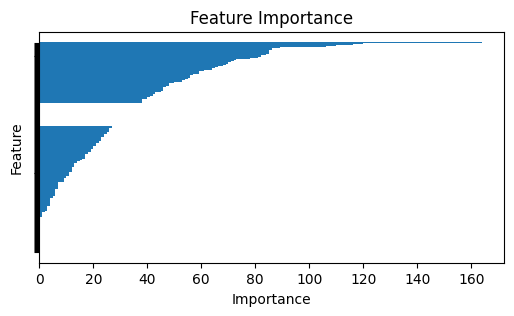

In [208]:
plt.figure(figsize=(6, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.yticks(range(len(importance_df)), [''] * len(importance_df))  # 축 항목 제거
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 상위 중요도 피처가 위에 오도록
plt.show()

In [209]:
filtered_columns = list(importance_df[importance_df['Importance'] > 50]['Feature'])
# _type에 따라 train, test 분리
X = train_df[filtered_columns]
X.head(3)

,hourly_market-data_open-interest_bitfinex_all_symbol_open_interest,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_open-interest_huobi_global_all_symbol_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_htx_global_taker_buy_volume,hourly_market-data_open-interest_huobi_global_btc_usdt_open_interest,hourly_network-data_transactions-count_transactions_count_mean,hourly_network-data_tokens-transferred_tokens_transferred_total,...,hourly_market-data_open-interest_kraken_btc_usd_open_interest,hourly_network-data_tokens-transferred_tokens_transferred_median,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume,hourly_market-data_open-interest_binance_all_symbol_open_interest,hourly_market-data_open-interest_okx_btc_usd_open_interest,hourly_market-data_open-interest_okx_all_symbol_open_interest,hourly_market-data_funding-rates_all_exchange_funding_rates,hourly_market-data_open-interest_binance_btc_usd_open_interest
0,1.085691e+08,0.0,16536.747967,1.019683e+08,5516.420322,1533800.0,415200.0,6.784288e+07,954.75,33057.024011,...,29584142.0,0.020125,1411658.0,766300.0,1610400.0,2.411675e+09,759976800.0,1.300604e+09,0.005049,339274900.0
1,1.087337e+08,0.0,16557.136536,1.024569e+08,4513.341881,403600.0,1027600.0,6.788941e+07,1458.00,12933.965951,...,29584162.0,0.021293,1174054.0,956000.0,1161200.0,2.415163e+09,760394000.0,1.302780e+09,0.005049,339254300.0
2,1.087549e+08,0.0,16548.149805,1.023375e+08,4310.904314,1005200.0,406600.0,6.781657e+07,693.75,26960.250177,...,29589085.0,0.022980,1494750.0,1860000.0,425100.0,2.416327e+09,760830100.0,1.301917e+09,0.005049,339752700.0


In [210]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.4217
AUROC: 0.5963

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4957
AUROC: 0.5533

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.2023
AUROC: 0.5555

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4416
AUROC: 0.6031

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [211]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.3983
Average AUROC: 0.5826


In [213]:
btscv = BlockingTimeSeriesSplit(n_splits=1)

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

In [214]:
import optuna

def objective(trial):
    # 하이퍼파라미터 검색 공간 정의
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # 모델 학습
    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )
    
    # 예측 및 평가
    y_valid_pred = model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    
    return accuracy


import logging

# 로그 레벨을 WARNING으로 설정
logging.basicConfig(level=logging.WARNING)

# Optuna study 생성 및 최적화 수행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2024-09-22 17:43:14,222] A new study created in memory with name: no-name-cb74a410-e951-493c-9d53-930aca72163a


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:14,502] Trial 0 finished with value: 0.4257990867579909 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.024128880356516273, 'n_estimators': 35, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.6601035787073934, 'colsample_bytree': 0.5088611578373132}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:15,007] Trial 1 finished with value: 0.10331050228310502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'learning_rate': 0.017355409114895602, 'n_estimators': 95, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.9472283103223966, 'colsample_bytree': 0.6994324050800009}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:15,569] Trial 2 finished with value: 0.4189497716894977 and parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'learning_rate': 0.002307747329683317, 'n_estimators': 69, 'max_depth': 9, 'min_child_samples': 35, 'subsample': 0.693717709944695, 'colsample_bytree': 0.9839100142322845}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:15,912] Trial 3 finished with value: 0.3082191780821918 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.014978889728669668, 'n_estimators': 49, 'max_depth': 5, 'min_child_samples': 33, 'subsample': 0.6697225611442592, 'colsample_bytree': 0.7370626419868869}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:16,069] Trial 4 finished with value: 0.4212328767123288 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.010525257580152549, 'n_estimators': 35, 'max_depth': 4, 'min_child_samples': 33, 'subsample': 0.9159614276578525, 'colsample_bytree': 0.5574658359573834}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:17,531] Trial 5 finished with value: 0.4178082191780822 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'learning_rate': 0.002108392225751786, 'n_estimators': 83, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.6657916511412858, 'colsample_bytree': 0.8127396285888111}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:17,896] Trial 6 finished with value: 0.3230593607305936 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'learning_rate': 0.011007127353429114, 'n_estimators': 48, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.6066303153746193, 'colsample_bytree': 0.9450923037052131}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:18,877] Trial 7 finished with value: 0.12728310502283105 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.011801394572480684, 'n_estimators': 87, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.6041982835083024, 'colsample_bytree': 0.9380072752182155}. Best is trial 0 with value: 0.4257990867579909.
[I 2024-09-22 17:43:19,053] Trial 8 finished with value: 0.1095890410958904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.014845409787872606, 'n_estimators': 59, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.8581530662385319, 'colsample_bytree': 0.9058950046739611}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:19,646] Trial 9 finished with value: 0.1095890410958904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'learning_rate': 0.05210023083069718, 'n_estimators': 91, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.6492332063859017, 'colsample_bytree': 0.7252675822010027}. Best is trial 0 with value: 0.4257990867579909.
[I 2024-09-22 17:43:19,870] Trial 10 finished with value: 0.3972602739726027 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'learning_rate': 0.04569907232423486, 'n_estimators': 21, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.506252018948816, 'colsample_bytree': 0.5036012644132373}. Best is trial 0 with value: 0.4257990867579909.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:19,987] Trial 11 finished with value: 0.4452054794520548 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.005667260858748174, 'n_estimators': 25, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.800478118551443, 'colsample_bytree': 0.5051170139913195}. Best is trial 11 with value: 0.4452054794520548.
[I 2024-09-22 17:43:20,087] Trial 12 finished with value: 0.4315068493150685 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.004151578725667116, 'n_estimators': 21, 'max_depth': 3, 'min_child_samples': 45, 'subsample': 0.7837547855728116, 'colsample_bytree': 0.6112538661189099}. Best is trial 11 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:20,191] Trial 13 finished with value: 0.4337899543378995 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'learning_rate': 0.004580272279699551, 'n_estimators': 20, 'max_depth': 3, 'min_child_samples': 47, 'subsample': 0.7848397981477695, 'colsample_bytree': 0.6296859629133934}. Best is trial 11 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:21,143] Trial 14 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'learning_rate': 0.004891800096898876, 'n_estimators': 33, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.7950036518801057, 'colsample_bytree': 0.6218025625786335}. Best is trial 11 with value: 0.4452054794520548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train 

[I 2024-09-22 17:43:21,330] Trial 15 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'learning_rate': 0.0011136739797941721, 'n_estimators': 27, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.8495888293218928, 'colsample_bytree': 0.6328874194256426}. Best is trial 11 with value: 0.4452054794520548.
[I 2024-09-22 17:43:21,545] Trial 16 finished with value: 0.4286529680365297 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.004664959500614671, 'n_estimators': 46, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.7569761670790041, 'colsample_bytree': 0.5695755989499556}. Best is trial 11 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:22,349] Trial 17 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.006344843120821185, 'n_estimators': 70, 'max_depth': 10, 'min_child_samples': 39, 'subsample': 0.9825870943636485, 'colsample_bytree': 0.6663189888932564}. Best is trial 11 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:22,682] Trial 18 finished with value: 0.4474885844748858 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.002572858140940917, 'n_estimators': 41, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.8459082575905724, 'colsample_bytree': 0.5666070901186615}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:23,131] Trial 19 finished with value: 0.4297945205479452 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.0023766196279503024, 'n_estimators': 40, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.8709100711405271, 'colsample_bytree': 0.8025606544116404}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:23,638] Trial 20 finished with value: 0.4309360730593607 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.0014990763579077761, 'n_estimators': 57, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7298263864904789, 'colsample_bytree': 0.5621360412632834}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:23,801] Trial 21 finished with value: 0.4349315068493151 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'learning_rate': 0.0032456262013282693, 'n_estimators': 28, 'max_depth': 4, 'min_child_samples': 45, 'subsample': 0.8192469282558753, 'colsample_bytree': 0.5450009802794951}. Best is trial 18 with value: 0.4474885844748858.
[I 2024-09-22 17:43:23,950] Trial 22 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.0031642576978355434, 'n_estimators': 28, 'max_depth': 4, 'min_child_samples': 44, 'subsample': 0.8324987202289235, 'colsample_bytree': 0.5345545895610889}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:24,658] Trial 23 finished with value: 0.4452054794520548 and parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'learning_rate': 0.006927065141005814, 'n_estimators': 40, 'max_depth': 6, 'min_child_samples': 37, 'subsample': 0.8975435446924722, 'colsample_bytree': 0.5021078193539628}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training fro

[I 2024-09-22 17:43:24,950] Trial 24 finished with value: 0.4360730593607306 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.007624462710254185, 'n_estimators': 42, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.8982413341598723, 'colsample_bytree': 0.5902928154553538}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:25,331] Trial 25 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.006788663313693633, 'n_estimators': 53, 'max_depth': 6, 'min_child_samples': 39, 'subsample': 0.930802143054679, 'colsample_bytree': 0.5246997294401605}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:25,606] Trial 26 finished with value: 0.09874429223744292 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.029459061792093604, 'n_estimators': 39, 'max_depth': 9, 'min_child_samples': 37, 'subsample': 0.876744465456478, 'colsample_bytree': 0.7838173068301577}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:26,078] Trial 27 finished with value: 0.4189497716894977 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.007468987494462154, 'n_estimators': 66, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.999788882432445, 'colsample_bytree': 0.6718862007912334}. Best is trial 18 with value: 0.4474885844748858.
[I 2024-09-22 17:43:26,294] Trial 28 finished with value: 0.4297945205479452 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'learning_rate': 0.0017349271704880744, 'n_estimators': 30, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.8153848712287403, 'colsample_bytree': 0.5837306814526126}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:26,638] Trial 29 finished with value: 0.4349315068493151 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'learning_rate': 0.022734299100247657, 'n_estimators': 37, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.9571198191448459, 'colsample_bytree': 0.5011702956490045}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:27,236] Trial 30 finished with value: 0.09703196347031963 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.07692240113055741, 'n_estimators': 44, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.7431696608057544, 'colsample_bytree': 0.8477218868477685}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:27,644] Trial 31 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.006156762164394089, 'n_estimators': 54, 'max_depth': 6, 'min_child_samples': 38, 'subsample': 0.9073776602161175, 'colsample_bytree': 0.528193147415092}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:28,455] Trial 32 finished with value: 0.4337899543378995 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.003546942434681079, 'n_estimators': 53, 'max_depth': 6, 'min_child_samples': 37, 'subsample': 0.9010903351377137, 'colsample_bytree': 0.5278468154700757}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:28,977] Trial 33 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'learning_rate': 0.005861218953748493, 'n_estimators': 65, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.9536383190233624, 'colsample_bytree': 0.5022491114157439}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:29,576] Trial 34 finished with value: 0.4218036529680365 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.008869673686960301, 'n_estimators': 76, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.9418891391734131, 'colsample_bytree': 0.5019451748232083}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:30,426] Trial 35 finished with value: 0.442351598173516 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.0026773486685938916, 'n_estimators': 100, 'max_depth': 10, 'min_child_samples': 34, 'subsample': 0.9593453453638483, 'colsample_bytree': 0.5764577840985321}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:31,339] Trial 36 finished with value: 0.4417808219178082 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'learning_rate': 0.005424087707655473, 'n_estimators': 64, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.8897206874714488, 'colsample_bytree': 0.5494328475880835}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:32,235] Trial 37 finished with value: 0.432648401826484 and parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.009140012741009469, 'n_estimators': 74, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.9219314801064522, 'colsample_bytree': 0.6036207670991095}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:32,599] Trial 38 finished with value: 0.4257990867579909 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'learning_rate': 0.013274649244630914, 'n_estimators': 33, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.8552483751335276, 'colsample_bytree': 0.6714941518012387}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:33,169] Trial 39 finished with value: 0.11986301369863013 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.017703706989740768, 'n_estimators': 64, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.7195302322949462, 'colsample_bytree': 0.5522059305462449}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:33,509] Trial 40 finished with value: 0.4292237442922374 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.0018818617567953287, 'n_estimators': 50, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.9742803404193908, 'colsample_bytree': 0.7101517268308668}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:33,949] Trial 41 finished with value: 0.4337899543378995 and parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'learning_rate': 0.006292209797412545, 'n_estimators': 56, 'max_depth': 7, 'min_child_samples': 38, 'subsample': 0.9176054132377685, 'colsample_bytree': 0.5224262718562563}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:34,345] Trial 42 finished with value: 0.432648401826484 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.0038054218376869556, 'n_estimators': 52, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.8372356620089768, 'colsample_bytree': 0.5275671488058803}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:34,700] Trial 43 finished with value: 0.4383561643835616 and parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'learning_rate': 0.009860346209229966, 'n_estimators': 46, 'max_depth': 8, 'min_child_samples': 40, 'subsample': 0.8831398907740526, 'colsample_bytree': 0.50399250677156}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:35,074] Trial 44 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.005490276249149626, 'n_estimators': 60, 'max_depth': 5, 'min_child_samples': 48, 'subsample': 0.8036876765434087, 'colsample_bytree': 0.5606562054775807}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:35,648] Trial 45 finished with value: 0.4394977168949772 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.0029970986647930983, 'n_estimators': 25, 'max_depth': 4, 'min_child_samples': 44, 'subsample': 0.7710006150834267, 'colsample_bytree': 0.59223536624246}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:35,938] Trial 46 finished with value: 0.4246575342465753 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.007971090526059838, 'n_estimators': 35, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9090004275129068, 'colsample_bytree': 0.6520966632606785}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 17:43:36,680] Trial 47 finished with value: 0.4286529680365297 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'learning_rate': 0.0040440879517305685, 'n_estimators': 79, 'max_depth': 6, 'min_child_samples': 35, 'subsample': 0.942022848685045, 'colsample_bytree': 0.5373922725884559}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 17:43:36,899] Trial 48 finished with value: 0.4389269406392694 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.00564087137127392, 'n_estimators': 24, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.8693045735315029, 'colsample_bytree': 0.5180866049814659}. Best is trial 18 with value: 0.4474885844748858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 17:43:37,526] Trial 49 finished with value: 0.1649543378995434 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.012292018261523683, 'n_estimators': 71, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.5158188410197588, 'colsample_bytree': 0.6090857332687805}. Best is trial 18 with value: 0.4474885844748858.


Best parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.002572858140940917, 'n_estimators': 41, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.8459082575905724, 'colsample_bytree': 0.5666070901186615}
Best score: 0.4474885844748858


In [215]:
# 최적 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["metric"] = "multi_logloss"
best_params["num_class"] = 4,
best_params["random_state"] = 42

final_model = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
)

# 최종 모델 예측 및 성능 평가
y_valid_pred = final_model.predict(X_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
accuracy = accuracy_score(y_valid, y_valid_pred_class)
print(f"Final model accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

**definition**  
정상성을 가진 데이터로 변환시킨 뒤 동일한 lgb + fold validation(k=5) + feature importance + optuna를 한 결과 성능이 더 좋진 않음..

##### VIF + 상관관계까지 적용한다면?

###### vif 확인

In [164]:
# data correlcation and VIF 확인

vif_df = sta_df[non_missing_columns]

# VIF 계산 함수
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    
    # VIF 계산
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# VIF 값 계산
vif_data = calculate_vif(vif_df)
vif_data.sort_values(by="VIF", ascending=False, inplace=True)

# VIF 10을 초과하는 컬럼 필터링
high_vif = vif_data[vif_data["VIF"] > 10]

# 상관관계 계산
correlations = vif_df.corr()

# VIF 10 이상인 컬럼 간 상관관계 및 VIF 값으로 새로운 데이터프레임 생성
results = []

# VIF 10 이상인 각 컬럼에 대해 상관관계와 VIF 값 추출
for i, col1 in enumerate(high_vif['Feature']):
    for col2 in high_vif['Feature'][i+1:]:
        corr_value = correlations.loc[col1, col2]
        vif_value1 = high_vif[high_vif['Feature'] == col1]['VIF'].values[0]
        vif_value2 = high_vif[high_vif['Feature'] == col2]['VIF'].values[0]
        results.append({'Column1': f'{col1}', 'Column2' : f'{col2}', 'Correlation': corr_value, 'VIF': max(vif_value1, vif_value2)})

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(results)
result_df.head(10)

,Column1,Column2,Correlation,VIF
0,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_liquidations_gate_io_btc_us...,0.517104,inf
1,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_open-interest_bitmex_all_sy...,0.041908,inf
2,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_liquidations_okx_btc_usdt_s...,0.415367,inf
3,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_liquidations_bitfinex_btc_u...,0.193464,inf
4,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_open-interest_htx_global_bt...,-0.008470,inf
5,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_open-interest_bitmex_btc_us...,0.041908,inf
6,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_liquidations_gate_io_all_sy...,0.513782,inf
7,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_liquidations_okx_btc_usdt_l...,0.027063,inf
8,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_liquidations_deribit_btc_us...,0.032561,inf
9,hourly_market-data_liquidations_bitmex_all_sym...,hourly_market-data_open-interest_kraken_btc_us...,-0.022552,inf


###### pca만 적용(accuracy : 0.453)

In [218]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [227]:
final_df_pca = sta_df.copy()

# _type에 따라 train, test 분리
train_df = final_df_pca.loc[final_df_pca["_type"]=="train"].drop(columns=["_type","ID",])

X = train_df.iloc[:,1:]
y = train_df['target']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [228]:
# PCA 적용
pca = PCA()  # 원하는 주성분의 수 설정
pca.fit(scaled_data)

# 각 주성분의 설명력
explained_variance = pca.explained_variance_ratio_
# 설명력의 누적 비율 계산
cumulative_variance = explained_variance.cumsum()

# 설명력이 0.8 이상이 되는 주성분 수 찾기
num_components = (cumulative_variance < 0.7).sum() + 1
num_components

17

In [234]:
pca = PCA(n_components=17)
pca_result = pca.fit_transform(scaled_data)
pca_result.shape
X = pd.DataFrame(pca_result)

In [235]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# 5개의 교차검증 실시
btscv = BlockingTimeSeriesSplit(n_splits=5)

In [236]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.4188
AUROC: 0.5983

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4758
AUROC: 0.5402

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.4131
AUROC: 0.5057

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4160
AUROC: 0.5826

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5
Accuracy: 0.4416
AUROC: 0.5912

Average Accuracy: 0.4330
Average AUROC: 0.5636


In [237]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.4330
Average AUROC: 0.5636


In [239]:
import optuna

btscv = BlockingTimeSeriesSplit(n_splits=1)

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]


def objective(trial):
    # 하이퍼파라미터 검색 공간 정의
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # 모델 학습
    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )
    
    # 예측 및 평가
    y_valid_pred = model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    
    return accuracy

# Optuna study 생성 및 최적화 수행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2024-09-22 18:18:38,863] A new study created in memory with name: no-name-1125ea8c-9dea-4b09-9f43-9b8b757ea687
[I 2024-09-22 18:18:38,983] Trial 0 finished with value: 0.442351598173516 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.013320117276513603, 'n_estimators': 32, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.5350962878662153, 'colsample_bytree': 0.911151357956742}. Best is trial 0 with value: 0.442351598173516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:39,423] Trial 1 finished with value: 0.4360730593607306 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'learning_rate': 0.0015833735343111835, 'n_estimators': 52, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.8458473979947768, 'colsample_bytree': 0.9450643277689079}. Best is trial 0 with value: 0.442351598173516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:40,158] Trial 2 finished with value: 0.4343607305936073 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.020732014185528697, 'n_estimators': 94, 'max_depth': 6, 'min_child_samples': 39, 'subsample': 0.6649666321146431, 'colsample_bytree': 0.7198420833166531}. Best is trial 0 with value: 0.442351598173516.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 18:18:41,564] Trial 3 finished with value: 0.4315068493150685 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.018630340147031733, 'n_estimators': 64, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.9588669114259909, 'colsample_bytree': 0.6252896322071553}. Best is trial 0 with value: 0.442351598173516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 18:18:41,830] Trial 4 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'learning_rate': 0.004482725958682928, 'n_estimators': 32, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.6558414291471639, 'colsample_bytree': 0.641497753540178}. Best is trial 0 with value: 0.442351598173516.
[I 2024-09-22 18:18:42,013] Trial 5 finished with value: 0.4320776255707763 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.031094031499785398, 'n_estimators': 29, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.736504429320878, 'colsample_bytree': 0.6598753019158248}. Best is trial 0 with value: 0.442351598173516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2

[I 2024-09-22 18:18:42,539] Trial 6 finished with value: 0.4280821917808219 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.013168509166282632, 'n_estimators': 57, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8209096466954499, 'colsample_bytree': 0.7128482709852839}. Best is trial 0 with value: 0.442351598173516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 18:18:43,251] Trial 7 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'learning_rate': 0.02009173945468691, 'n_estimators': 83, 'max_depth': 7, 'min_child_samples': 33, 'subsample': 0.6916848917029543, 'colsample_bytree': 0.8642473486873352}. Best is trial 7 with value: 0.4434931506849315.
[I 2024-09-22 18:18:43,433] Trial 8 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.010405692740644241, 'n_estimators': 29, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.8451492767299331, 'colsample_bytree': 0.6927760152080069}. Best is trial 7 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2

[I 2024-09-22 18:18:43,734] Trial 9 finished with value: 0.444634703196347 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'learning_rate': 0.00222221899920287, 'n_estimators': 95, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.6834406989449908, 'colsample_bytree': 0.6060334662077382}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:43,950] Trial 10 finished with value: 0.4297945205479452 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'learning_rate': 0.09649525448014264, 'n_estimators': 100, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.5080860911639259, 'colsample_bytree': 0.5003012950812442}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:44,967] Trial 11 finished with value: 0.4360730593607306 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.00323676623568968, 'n_estimators': 81, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.6438999814649076, 'colsample_bytree': 0.8304151949163265}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:45,510] Trial 12 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'learning_rate': 0.001075297755097675, 'n_estimators': 81, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.7310548914946408, 'colsample_bytree': 0.8218255778013117}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 18:18:46,007] Trial 13 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.004100350075618551, 'n_estimators': 83, 'max_depth': 6, 'min_child_samples': 39, 'subsample': 0.5950746073932396, 'colsample_bytree': 0.532585265925487}. Best is trial 9 with value: 0.444634703196347.
[I 2024-09-22 18:18:46,232] Trial 14 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'learning_rate': 0.047860582414288214, 'n_estimators': 70, 'max_depth': 3, 'min_child_samples': 34, 'subsample': 0.7795339718733187, 'colsample_bytree': 0.8043405513269268}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `forc

[I 2024-09-22 18:18:46,750] Trial 15 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'learning_rate': 0.005992413989057921, 'n_estimators': 91, 'max_depth': 5, 'min_child_samples': 45, 'subsample': 0.7058144104081258, 'colsample_bytree': 0.9935275669868016}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 secon

[I 2024-09-22 18:18:47,342] Trial 16 finished with value: 0.4343607305936073 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.0019999302890588815, 'n_estimators': 72, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.5866846581523917, 'colsample_bytree': 0.5728790952067615}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 18:18:47,726] Trial 17 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.0070605041698823, 'n_estimators': 49, 'max_depth': 7, 'min_child_samples': 35, 'subsample': 0.8979425882077146, 'colsample_bytree': 0.7684811462921919}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:48,974] Trial 18 finished with value: 0.4412100456621005 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.06759769339864882, 'n_estimators': 100, 'max_depth': 5, 'min_child_samples': 44, 'subsample': 0.5967932972795462, 'colsample_bytree': 0.8912377176700012}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:49,644] Trial 19 finished with value: 0.4349315068493151 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.0025093413413624917, 'n_estimators': 88, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7936263654255584, 'colsample_bytree': 0.5740931510623293}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:50,055] Trial 20 finished with value: 0.4366438356164384 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 0.03378576541666584, 'n_estimators': 75, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.679347509886933, 'colsample_bytree': 0.8559897779546755}. Best is trial 9 with value: 0.444634703196347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:50,296] Trial 21 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'learning_rate': 0.05041692563389397, 'n_estimators': 70, 'max_depth': 3, 'min_child_samples': 33, 'subsample': 0.7727110412388882, 'colsample_bytree': 0.7837593611772518}. Best is trial 21 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:50,508] Trial 22 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'learning_rate': 0.029471528206164697, 'n_estimators': 63, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.7586205800952814, 'colsample_bytree': 0.7627568485484225}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of u

[I 2024-09-22 18:18:50,969] Trial 23 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'learning_rate': 0.03803242756782132, 'n_estimators': 42, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.758840459384259, 'colsample_bytree': 0.7454714909498805}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-22 18:18:51,220] Trial 24 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'learning_rate': 0.04531614659183561, 'n_estimators': 42, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.7683814090586432, 'colsample_bytree': 0.7682546578204948}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-22 18:18:51,313] Trial 25 finished with value: 0.4480593607305936 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'learning_rate': 0.08445204134136425, 'n_estimators': 21, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.8965454001183422, 'colsample_bytree': 0.744653955197458}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start t

[I 2024-09-22 18:18:51,611] Trial 26 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.057012575116050714, 'n_estimators': 63, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.799718000532929, 'colsample_bytree': 0.7881337086192307}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:52,166] Trial 27 finished with value: 0.444634703196347 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.028646302633183577, 'n_estimators': 43, 'max_depth': 3, 'min_child_samples': 31, 'subsample': 0.7453064661202651, 'colsample_bytree': 0.6797488883998727}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:52,521] Trial 28 finished with value: 0.4417808219178082 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'learning_rate': 0.0391840145394008, 'n_estimators': 56, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8907183127349937, 'colsample_bytree': 0.7323156241434506}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:52,729] Trial 29 finished with value: 0.4440639269406393 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.023254563905752694, 'n_estimators': 42, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.8383962479801613, 'colsample_bytree': 0.7874787614713374}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:53,053] Trial 30 finished with value: 0.4366438356164384 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.06672961389686453, 'n_estimators': 67, 'max_depth': 4, 'min_child_samples': 37, 'subsample': 0.7153984745830071, 'colsample_bytree': 0.9261153199246215}. Best is trial 22 with value: 0.4503424657534247.
[I 2024-09-22 18:18:53,199] Trial 31 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.045316815530762763, 'n_estimators': 42, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.7666595746678223, 'colsample_bytree': 0.7518629893993685}. Best is trial 22 with value: 0.4503424657534247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[Lig

[I 2024-09-22 18:18:53,364] Trial 32 finished with value: 0.4520547945205479 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'learning_rate': 0.05298922898358969, 'n_estimators': 48, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.7582050495077961, 'colsample_bytree': 0.7653218655617684}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:53,777] Trial 33 finished with value: 0.432648401826484 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'learning_rate': 0.02656175860897181, 'n_estimators': 48, 'max_depth': 6, 'min_child_samples': 31, 'subsample': 0.8244796443883053, 'colsample_bytree': 0.7052862537792938}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:54,000] Trial 34 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'learning_rate': 0.07745679155548059, 'n_estimators': 59, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.6369488059796287, 'colsample_bytree': 0.8521581178974967}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2024-09-22 18:18:54,244] Trial 35 finished with value: 0.4389269406392694 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'learning_rate': 0.01319022908215445, 'n_estimators': 52, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.8758097598778584, 'colsample_bytree': 0.8172205472873023}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:54,659] Trial 36 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.05565329540259827, 'n_estimators': 63, 'max_depth': 5, 'min_child_samples': 33, 'subsample': 0.7543844783080625, 'colsample_bytree': 0.6582865412465833}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:54,916] Trial 37 finished with value: 0.4492009132420091 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.018569893111615103, 'n_estimators': 76, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9345127710429768, 'colsample_bytree': 0.7310218481681883}. Best is trial 32 with value: 0.4520547945205479.
[I 2024-09-22 18:18:55,093] Trial 38 finished with value: 0.4406392694063927 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'learning_rate': 0.015659002915292927, 'n_estimators': 35, 'max_depth': 4, 'min_child_samples': 38, 'subsample': 0.8103633193098295, 'colsample_bytree': 0.7719147682942396}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:55,371] Trial 39 finished with value: 0.4355022831050228 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.037738035397993135, 'n_estimators': 36, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.7247530996405458, 'colsample_bytree': 0.8796536584591198}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start t

[I 2024-09-22 18:18:55,994] Trial 40 finished with value: 0.4474885844748858 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'learning_rate': 0.023412316279168746, 'n_estimators': 54, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.863377654776166, 'colsample_bytree': 0.6870136156176717}. Best is trial 32 with value: 0.4520547945205479.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-22 18:18:56,159] Trial 41 finished with value: 0.4526255707762557 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'learning_rate': 0.044407190216732985, 'n_estimators': 45, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.7699310893602815, 'colsample_bytree': 0.759208487376693}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of u

[I 2024-09-22 18:18:56,426] Trial 42 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.05599124309712609, 'n_estimators': 47, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7844642932677277, 'colsample_bytree': 0.7201982099298593}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:56,562] Trial 43 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'learning_rate': 0.03292280280911283, 'n_estimators': 36, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.7604071394693537, 'colsample_bytree': 0.8009382260352731}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2

[I 2024-09-22 18:18:56,848] Trial 44 finished with value: 0.4383561643835616 and parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'learning_rate': 0.04184434069845122, 'n_estimators': 60, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.6964219235322957, 'colsample_bytree': 0.8387901566484183}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:57,415] Trial 45 finished with value: 0.420662100456621 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'learning_rate': 0.09441913452827666, 'n_estimators': 53, 'max_depth': 11, 'min_child_samples': 33, 'subsample': 0.7432852547104237, 'colsample_bytree': 0.7521144220305183}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-22 18:18:57,571] Trial 46 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.06820992982637052, 'n_estimators': 45, 'max_depth': 3, 'min_child_samples': 41, 'subsample': 0.8155248879404665, 'colsample_bytree': 0.7108241630532945}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 18:18:58,003] Trial 47 finished with value: 0.4252283105022831 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.07420434532436465, 'n_estimators': 67, 'max_depth': 5, 'min_child_samples': 41, 'subsample': 0.825307423135495, 'colsample_bytree': 0.6321208501093801}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:58,216] Trial 48 finished with value: 0.4394977168949772 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.05675894356996559, 'n_estimators': 47, 'max_depth': 4, 'min_child_samples': 43, 'subsample': 0.987591622044421, 'colsample_bytree': 0.6582402008069543}. Best is trial 41 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 18:18:58,345] Trial 49 finished with value: 0.4531963470319635 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.06505323380184888, 'n_estimators': 26, 'max_depth': 3, 'min_child_samples': 31, 'subsample': 0.8558580923265104, 'colsample_bytree': 0.7094747739798161}. Best is trial 49 with value: 0.4531963470319635.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.06505323380184888, 'n_estimators': 26, 'max_depth': 3, 'min_child_samples': 31, 'subsample': 0.8558580923265104, 'colsample_bytree': 0.7094747739798161}
Best score: 0.4531963470319635


In [240]:
# 최적 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["metric"] = "multi_logloss"
best_params["num_class"] = 4,
best_params["random_state"] = 42

final_model = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
)

# 최종 모델 예측 및 성능 평가
y_valid_pred = final_model.predict(X_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
accuracy = accuracy_score(y_valid, y_valid_pred_class)
print(f"Final model accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 17
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Final model accuracy: 0.4531963470319635


###### vif와 correlation으로 변수 제거만(accuracy : 0.4566)

In [165]:
# 변수 중복 제거를 위한 세트
to_remove = set()

# 높은 상관관계를 가진 변수 쌍 중 하나만 남기기
for col1, col2 in zip(result_df['Column1'], result_df['Column2']):
    if col1 not in to_remove and col2 not in to_remove:
        to_remove.add(col2)  # col2를 제거 목록에 추가 (col1은 남김)

# 결과 데이터프레임 생성
removed_vars = list(to_remove)
len(removed_vars)

188

In [166]:
non_missing_columns
vif_columns = set(list(result_df['Column1']) + list(result_df['Column2']))

# vif가 10이 넘는 변수 쌍이 아예 존재하지 않는 변수들
non_vif_columns = [col for col in non_missing_columns if col not in vif_columns]

# vif가 10이 넘는 변수들 중에서 중복된 값들 제거
new_1 = [col for col in non_missing_columns if ( (col in set(list(result_df['Column2']))) & (col in set(list(result_df['Column1']))) ) == False]

In [167]:
final_df = sta_df[['target']+ new_1]
final_test_df = sta_test_df[['target'] + new_1]
final_df.head(3)

,target,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_network-data_block-interval_block_interval,hourly_network-data_block-bytes_block_bytes,hourly_network-data_tokens-transferred_tokens_transferred_mean,hourly_market-data_funding-rates_huobi_global_funding_rates,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_sell_ratio,...,hourly_market-data_liquidations_bitmex_all_symbol_short_liquidations_usd,hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_sell_ratio,hourly_market-data_funding-rates_all_exchange_funding_rates,hourly_network-data_supply_supply_total,hourly_network-data_fees-transaction_fees_transaction_median_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_network-data_tokens-transferred_tokens_transferred_total,hourly_network-data_tokens-transferred_tokens_transferred_median,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2.0,0.01,0.588133,0.411867,1.427970,427.333333,783554.416667,2.885312,0.01,0.475845,...,0.0,0.905398,0.005049,1.924871e+07,0.235973,5516.420322,33057.024011,0.020125,0.01,0.0
1,1.0,0.01,0.774509,0.225491,3.434766,782.500000,890760.500000,2.217758,0.01,0.823286,...,0.0,3.714817,0.005049,1.924874e+07,0.237108,4513.341881,12933.965951,0.021293,0.01,0.0
2,1.0,0.01,0.364570,0.635430,0.573738,365.125000,558209.750000,4.857703,0.01,4.375441,...,0.0,1.672801,0.005049,1.924879e+07,0.234878,4310.904314,26960.250177,0.022980,0.01,0.0


In [168]:
X = final_df.iloc[:,1:]
y = final_df['target']

In [169]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# 5개의 교차검증 실시
btscv = BlockingTimeSeriesSplit(n_splits=5)

In [170]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.3960
AUROC: 0.5701

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4444
AUROC: 0.5544

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.4387
AUROC: 0.5235

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4758
AUROC: 0.5844

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5
Accuracy: 0.4416
AUROC: 0.6126

Average Accuracy: 0.4393
Average AUROC: 0.5690


In [171]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.4393
Average AUROC: 0.5690


In [172]:
feature_importances = final_lgb_model.feature_importance(importance_type='split')
feature_names = X.columns
# 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도에 따라 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 100 이하 제거
filtered_columns = list(importance_df[importance_df['Importance'] > 100]['Feature'])

# X 재설정 
X = final_df[filtered_columns]
X.head(3)

,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_network-data_supply_supply_total,hourly_network-data_tokens-transferred_tokens_transferred_total,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_sell_ratio,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_sell_ratio,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd,hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_sell_ratio,hourly_network-data_block-interval_block_interval,hourly_network-data_block-bytes_block_bytes,hourly_market-data_funding-rates_deribit_funding_rates,...,hourly_network-data_tokens-transferred_tokens_transferred_mean,hourly_market-data_coinbase-premium-index_coinbase_premium_gap,hourly_network-data_fees-transaction_fees_transaction_median_usd,hourly_network-data_tokens-transferred_tokens_transferred_median,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_funding-rates_all_exchange_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_funding-rates_bitmex_funding_rates,hourly_market-data_funding-rates_bybit_funding_rates
0,5516.420322,1.924871e+07,33057.024011,0.475845,1.493922,0.0,0.905398,427.333333,783554.416667,0.000571,...,2.885312,-9.86,0.235973,0.020125,0.01,0.588133,0.005049,0.411867,0.0014,0.01
1,4513.341881,1.924874e+07,12933.965951,0.823286,3.964774,0.0,3.714817,782.500000,890760.500000,0.000570,...,2.217758,-8.78,0.237108,0.021293,0.01,0.774509,0.005049,0.225491,0.0014,0.01
2,4310.904314,1.924879e+07,26960.250177,4.375441,0.286114,0.0,1.672801,365.125000,558209.750000,0.000566,...,4.857703,-9.59,0.234878,0.022980,0.01,0.364570,0.005049,0.635430,0.0014,0.01


In [173]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.4444
AUROC: 0.5911

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4729
AUROC: 0.5882

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.4245
AUROC: 0.5174

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4615
AUROC: 0.5723

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5
Accuracy: 0.

In [174]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.4422
Average AUROC: 0.5733


In [175]:
btscv = BlockingTimeSeriesSplit(n_splits=1)

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]



def objective(trial):
    # 하이퍼파라미터 검색 공간 정의
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # 모델 학습
    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )
    
    # 예측 및 평가
    y_valid_pred = model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    
    return accuracy

# Optuna study 생성 및 최적화 수행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2024-09-22 21:36:00,368] A new study created in memory with name: no-name-75847f6c-fea7-405c-8c63-a870ff217d16
[I 2024-09-22 21:36:00,537] Trial 0 finished with value: 0.4269406392694064 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'learning_rate': 0.055685517726891905, 'n_estimators': 51, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.6127271280268639, 'colsample_bytree': 0.6626707922833078}. Best is trial 0 with value: 0.4269406392694064.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 21:36:01,601] Trial 1 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'learning_rate': 0.003765963897804355, 'n_estimators': 95, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.5703526157541134, 'colsample_bytree': 0.5396306945096081}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:02,251] Trial 2 finished with value: 0.4275114155251142 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'learning_rate': 0.015633224761781972, 'n_estimators': 83, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.5315672516449661, 'colsample_bytree': 0.7681796788142949}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:02,981] Trial 3 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.0023297735470214176, 'n_estimators': 98, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8572294582534679, 'colsample_bytree': 0.9417189004466412}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 21:36:04,148] Trial 4 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.036848600518515774, 'n_estimators': 95, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.5253722280977718, 'colsample_bytree': 0.9657366588539869}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:04,742] Trial 5 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.014771399546598125, 'n_estimators': 66, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.6572501407759105, 'colsample_bytree': 0.8892212067536837}. Best is trial 1 with value: 0.4434931506849315.
[I 2024-09-22 21:36:04,823] Trial 6 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.019919246699012853, 'n_estimators': 22, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.9932189828057556, 'colsample_bytree': 0.7925019350468716}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 21:36:05,412] Trial 7 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'learning_rate': 0.006678063451577765, 'n_estimators': 65, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7702947813451682, 'colsample_bytree': 0.7003717210283193}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-09-22 21:36:05,732] Trial 8 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'learning_rate': 0.010686400571848088, 'n_estimators': 77, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.9666482860901214, 'colsample_bytree': 0.8873950362624862}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 21:36:06,264] Trial 9 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'learning_rate': 0.0012361518572550645, 'n_estimators': 70, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.9399635085671861, 'colsample_bytree': 0.7817532163887335}. Best is trial 1 with value: 0.4434931506849315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:06,577] Trial 10 finished with value: 0.4452054794520548 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.004557086886514762, 'n_estimators': 45, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.6950678828436848, 'colsample_bytree': 0.5480600604710377}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:07,239] Trial 11 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.0038910188057033326, 'n_estimators': 44, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.6966928497865327, 'colsample_bytree': 0.5050495351036148}. Best is trial 10 with value: 0.4452054794520548.
[I 2024-09-22 21:36:07,447] Trial 12 finished with value: 0.4406392694063927 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.00409895730842238, 'n_estimators': 34, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.7521747339446438, 'colsample_bytree': 0.5247636973331703}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2

[I 2024-09-22 21:36:07,821] Trial 13 finished with value: 0.4349315068493151 and parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'learning_rate': 0.0010477487127678493, 'n_estimators': 54, 'max_depth': 8, 'min_child_samples': 36, 'subsample': 0.6082761332137319, 'colsample_bytree': 0.5916403951812701}. Best is trial 10 with value: 0.4452054794520548.
[I 2024-09-22 21:36:08,056] Trial 14 finished with value: 0.4394977168949772 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.0026958990208759337, 'n_estimators': 39, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.5886845652247599, 'colsample_bytree': 0.6188150334689121}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start t

[I 2024-09-22 21:36:08,765] Trial 15 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.006534849981829482, 'n_estimators': 86, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8272544328733679, 'colsample_bytree': 0.5486454319751808}. Best is trial 10 with value: 0.4452054794520548.
[I 2024-09-22 21:36:08,942] Trial 16 finished with value: 0.4315068493150685 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.0016797554970903494, 'n_estimators': 26, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.6906207094472461, 'colsample_bytree': 0.5980939098004234}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2

[I 2024-09-22 21:36:09,125] Trial 17 finished with value: 0.4372146118721461 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.0054831013997411904, 'n_estimators': 56, 'max_depth': 3, 'min_child_samples': 36, 'subsample': 0.5682244933967393, 'colsample_bytree': 0.6997666324179111}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 21:36:09,557] Trial 18 finished with value: 0.4366438356164384 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.09153156082254763, 'n_estimators': 49, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.6693325574530102, 'colsample_bytree': 0.5607983953860143}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:09,761] Trial 19 finished with value: 0.4383561643835616 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.002718993072246914, 'n_estimators': 30, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.8138110922782924, 'colsample_bytree': 0.6404427208855261}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2024-09-22 21:36:11,134] Trial 20 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'learning_rate': 0.008115587505129022, 'n_estimators': 89, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.7244256296338961, 'colsample_bytree': 0.7169247225884974}. Best is trial 10 with value: 0.4452054794520548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 secon

[I 2024-09-22 21:36:11,772] Trial 21 finished with value: 0.4492009132420091 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.004523150324048001, 'n_estimators': 81, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8832140753032496, 'colsample_bytree': 0.5476577185440716}. Best is trial 21 with value: 0.4492009132420091.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:12,319] Trial 22 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.0038819813198741953, 'n_estimators': 78, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.893789664356703, 'colsample_bytree': 0.5670151471898062}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:12,858] Trial 23 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.001734463458069784, 'n_estimators': 75, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8967233696751212, 'colsample_bytree': 0.5770760574330519}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:13,509] Trial 24 finished with value: 0.4355022831050228 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.01082535177975018, 'n_estimators': 77, 'max_depth': 9, 'min_child_samples': 31, 'subsample': 0.9022867864715218, 'colsample_bytree': 0.6574409367639009}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:13,974] Trial 25 finished with value: 0.4417808219178082 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.004760293242349455, 'n_estimators': 60, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.8001427555456498, 'colsample_bytree': 0.5016782357787112}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:14,666] Trial 26 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'learning_rate': 0.0028597874638806413, 'n_estimators': 41, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.8722044729731614, 'colsample_bytree': 0.6187376998273126}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:15,310] Trial 27 finished with value: 0.4349315068493151 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'learning_rate': 0.0018609415993654267, 'n_estimators': 81, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9253539356523397, 'colsample_bytree': 0.835483112266318}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:15,852] Trial 28 finished with value: 0.4492009132420091 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.008330901087554441, 'n_estimators': 71, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.7759006003948797, 'colsample_bytree': 0.567274355723514}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:16,412] Trial 29 finished with value: 0.4115296803652968 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.02906635204894693, 'n_estimators': 71, 'max_depth': 10, 'min_child_samples': 42, 'subsample': 0.8520525621988253, 'colsample_bytree': 0.6667846679914913}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.4

[I 2024-09-22 21:36:17,442] Trial 30 finished with value: 0.4337899543378995 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.009107433970935717, 'n_estimators': 90, 'max_depth': 11, 'min_child_samples': 33, 'subsample': 0.7792644385023095, 'colsample_bytree': 0.737523157701308}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:18,364] Trial 31 finished with value: 0.444634703196347 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.005837725766697557, 'n_estimators': 60, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7260085451259781, 'colsample_bytree': 0.5662541220810254}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:18,841] Trial 32 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.0033959922032607177, 'n_estimators': 67, 'max_depth': 9, 'min_child_samples': 37, 'subsample': 0.6430557674437103, 'colsample_bytree': 0.5321191578521338}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:19,470] Trial 33 finished with value: 0.4412100456621005 and parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.013231733346540608, 'n_estimators': 81, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.8885624957704974, 'colsample_bytree': 0.6101874602820618}. Best is trial 22 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:19,850] Trial 34 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.0047680767674029775, 'n_estimators': 47, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8397914074004473, 'colsample_bytree': 0.5381604867948574}. Best is trial 34 with value: 0.4503424657534247.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:20,462] Trial 35 finished with value: 0.4514840182648402 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.007912645599848727, 'n_estimators': 71, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8434595650197282, 'colsample_bytree': 0.5221061247295836}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:22,108] Trial 36 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'learning_rate': 0.003580467195686374, 'n_estimators': 85, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.852512896303786, 'colsample_bytree': 0.5064247206677404}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:22,508] Trial 37 finished with value: 0.4343607305936073 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.019964417267439704, 'n_estimators': 51, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8347837701923551, 'colsample_bytree': 0.5867398467539603}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:23,338] Trial 38 finished with value: 0.4406392694063927 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.0020826520689217237, 'n_estimators': 98, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9255639812025281, 'colsample_bytree': 0.6424170221726295}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:24,321] Trial 39 finished with value: 0.4383561643835616 and parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'learning_rate': 0.007430572647940894, 'n_estimators': 92, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9578391686434609, 'colsample_bytree': 0.534195725852517}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:24,823] Trial 40 finished with value: 0.4355022831050228 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.0056773304005604645, 'n_estimators': 62, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9890220365446147, 'colsample_bytree': 0.9875556446633822}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:25,821] Trial 41 finished with value: 0.432648401826484 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.01164391056986731, 'n_estimators': 78, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8016739018838804, 'colsample_bytree': 0.5606734767784358}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:26,414] Trial 42 finished with value: 0.4366438356164384 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.017111874983569603, 'n_estimators': 73, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8802809964521159, 'colsample_bytree': 0.526458680356863}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:26,977] Trial 43 finished with value: 0.4452054794520548 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.00950523447253495, 'n_estimators': 68, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.7838538978935794, 'colsample_bytree': 0.5807072147411793}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:27,499] Trial 44 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.004936341780583053, 'n_estimators': 64, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8366510523785148, 'colsample_bytree': 0.5410519752686076}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:28,100] Trial 45 finished with value: 0.4315068493150685 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.007461824111133105, 'n_estimators': 73, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9111351252440152, 'colsample_bytree': 0.5001284870463273}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-22 21:36:29,138] Trial 46 finished with value: 0.4394977168949772 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.0036242166684225677, 'n_estimators': 81, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8646017327870084, 'colsample_bytree': 0.6329127897889459}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:29,796] Trial 47 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.0043518997991277356, 'n_estimators': 57, 'max_depth': 10, 'min_child_samples': 31, 'subsample': 0.7490622266587397, 'colsample_bytree': 0.6035696330645496}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:30,161] Trial 48 finished with value: 0.442351598173516 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.003112153487799247, 'n_estimators': 56, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.751188640149915, 'colsample_bytree': 0.6077114992805465}. Best is trial 35 with value: 0.4514840182648402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 21:36:30,454] Trial 49 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.0022837248395003638, 'n_estimators': 44, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7235246629787401, 'colsample_bytree': 0.520626313532748}. Best is trial 35 with value: 0.4514840182648402.


Best parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.007912645599848727, 'n_estimators': 71, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8434595650197282, 'colsample_bytree': 0.5221061247295836}
Best score: 0.4514840182648402


In [176]:
# 최적 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["metric"] = "multi_logloss"
best_params["num_class"] = 4,
best_params["random_state"] = 42

final_model = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
)

# 최종 모델 예측 및 성능 평가
y_valid_pred = final_model.predict(X_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
accuracy = accuracy_score(y_valid, y_valid_pred_class)
print(f"Final model accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 21
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
Final model accuracy: 0.4514840182648402


In [177]:
# performance 체크후 전체 학습 데이터로 다시 재학습
train_data = lgb.Dataset(X, label=y)
final_model = lgb.train(
    params=best_params,
    train_set=train_data,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5328
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 21
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109


In [178]:
final_test_df = final_test_df[filtered_columns]

In [179]:
# lgb predict
y_test_pred = final_model.predict(final_test_df)
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [180]:
# output file 할당후 save
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_stationality_fixed_0922.csv", index=False)

-----------------------------------

###### fixed와 non_fixed target 값 차이 확인해보기

In [181]:
# 파일 호출
non_fixed_df = pd.read_csv("output/output_stationarity_0922.csv")
fixed_df = pd.read_csv("output/output_stationality_fixed_0922.csv")

In [183]:
comparison = non_fixed_df != fixed_df

# 값이 다를 경우(True)의 개수를 셈
num_different_values = comparison.sum().sum()
num_different_values

406

##### catboost

In [278]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

X = sta_df.iloc[:,3:]
y = sta_df['target']

In [279]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoost 모델 생성
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.07      0.12       149
         1.0       0.41      0.49      0.45       678
         2.0       0.44      0.52      0.48       745
         3.0       0.37      0.09      0.15       180

    accuracy                           0.43      1752
   macro avg       0.39      0.29      0.30      1752
weighted avg       0.41      0.43      0.40      1752



In [281]:
# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    depth = trial.suggest_int('depth', 5, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    iterations = trial.suggest_int('iterations', 100, 500)
    
    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        verbose=0,
        random_state=42
    )
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

[I 2024-09-22 19:10:40,985] A new study created in memory with name: no-name-2640d048-d11b-4f6f-a30e-3826e937dc33
[I 2024-09-22 19:12:08,403] Trial 0 finished with value: 0.432648401826484 and parameters: {'depth': 10, 'learning_rate': 0.05588427851611928, 'iterations': 209}. Best is trial 0 with value: 0.432648401826484.
[I 2024-09-22 19:12:16,958] Trial 1 finished with value: 0.4394977168949772 and parameters: {'depth': 6, 'learning_rate': 0.015606499172260048, 'iterations': 248}. Best is trial 1 with value: 0.4394977168949772.
[I 2024-09-22 19:12:55,129] Trial 2 finished with value: 0.4332191780821918 and parameters: {'depth': 8, 'learning_rate': 0.028395976064823355, 'iterations': 382}. Best is trial 1 with value: 0.4394977168949772.
[I 2024-09-22 19:13:12,033] Trial 3 finished with value: 0.4429223744292237 and parameters: {'depth': 7, 'learning_rate': 0.08741190750953017, 'iterations': 265}. Best is trial 3 with value: 0.4429223744292237.
[I 2024-09-22 19:14:19,134] Trial 4 finis

KeyboardInterrupt: 